In [225]:
import requests
import json
import urllib.parse
from bs4 import BeautifulSoup
from time import sleep
from tqdm import tqdm
import re
import numpy as np
import pandas as pd
import sys
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install google-cloud-storage
!{sys.executable} -m pip install gspread
!{sys.executable} -m pip install geojson
!{sys.executable} -m pip install pyproj
!{sys.executable} -m pip install shapely
import geojson
import pyproj
import shapely
import os 
import folium
from folium import plugins
from folium.plugins import HeatMap
import gspread
from sklearn.neighbors import BallTree, KDTree
import matplotlib.pyplot as plt
key = "AM7LjnAbKGftHgENhda9uLTjG4qHZAj1"

In [196]:
class Shop:
    '''
    This class serves for creation of specific shop objects with needed characteristics such as address, gps, phone number, etc.
        '''
    
    def __init__(self,link=""):
        soup = getSoup(link)
        soup_dr = getSoup(parse_druzstvo_link(soup))
        gps = get_GPS(soup)
        self.id = link
        self.name = parse_name(soup)
        self.address = parse_address(soup)
        self.phone = parse_phone(soup)
        self.mail = parse_mail(soup)
        self.webpage = parse_link(soup)
        self.druzstvo = parse_druzstvo(soup)
        # self.address_dr = parse_address(soup_dr)
        self.phone_dr = parse_phone(soup_dr)
        self.mail_dr = parse_mail(soup_dr)
        self.webpage_dr = parse_link(soup_dr)
        self.lat = gps[0]
        self.lng = gps[1]
        self.town = findMeTown(S=True, link=link)

    def giveArray(self):
        return pd.Series({
        'id':self.id,
        'name':self.name,
        'address':self.sddress,
        'phone':self.phone,
        'mail':self.mail,
        'webpage':self.webpage,
        'druzstvo':self.druzstvo,
        'phone_dr':self.phone_dr,
        'mail_dr':self.mail_dr,
        'webpage_dr':self.webpage_dr,
        'lat':self.lat,
        'lng':self.lng,
        'town':self.town
    })

In [222]:
class Database:
    '''
    This class serves for quicker loading of dataframes from Google Sheets.
        '''
    
    def __init__(self,sheet="",worksheet=""):
        self.gc = gspread.service_account(filename="credentials.json")
        self.sh = self.gc.open(sheet)
        self.wsheet = self.sh.worksheet(worksheet)
        all_rows = self.wsheet.get_all_values()
        columns = all_rows.pop(0)
        self.df = pd.DataFrame(all_rows,columns=columns)
        
    def update (self, newdf):
        self.wsheet.update([newdf.columns.values.tolist()] + newdf.values.tolist())
        
shopData = Database(sheet="Shops",worksheet="data")
townData = Database(sheet="Shops",worksheet="town")
shopData.df

id  \
0     https://www.skupina.coop/coop-hrubinova-187-ne...   
1     https://www.skupina.coop/coop-husova-471-votic...   
2     https://www.skupina.coop/coop-1-maje-175-hrade...   
3     https://www.skupina.coop/coop-benesovska-265-p...   
4     https://www.skupina.coop/coop-bezrucova-1064-b...   
...                                                 ...   
2497   https://www.skupina.coop/coop-zubri-82-zubri-336   
2498  https://www.skupina.coop/coop-zubri-847-zubri-337   
2499  https://www.skupina.coop/coop-zverkovice-24-mo...   
2500  https://www.skupina.coop/coop-zvole-158-zvole-431   
2501    https://www.skupina.coop/coop-zvole-6-zvole-192   

                                         name  \
0               COOP Hrubínova 187, Netvořice   
1                     COOP Husova 471, Votice   
2                    COOP 1. máje 175, Hrádek   
3     COOP Benešovská 265, Poříčí nad Sázavou   
4                COOP Bezručova 1064, Benešov   
...                                       ...   
2497                     COOP Zubří 82, Zubří   
2498                    COOP Zubří 847, Zubří   
2499  COOP Zvěrkovice 24, Moravské Budějovice   
2500                    COOP Zvole 158, Zvole   
2501                    COOP Zvole   6, Zvole   

                                                address        phone mail  \
0              Hrubínova 187, 257 44 Netvořice, Benešov  317 789 264    -   
1                    Husova 471, 259 01 Votice, Benešov  317 812 530    -   
2                  1. máje 175, 338 42 Hrádek, Rokycany  371 787 372    -   
3     Benešovská 265, 257 21 Poříčí nad Sázavou, Ben...  317 779 210    -   
4               Bezručova 1064, 256 01 Benešov, Benešov  317 728 292    -   
...                                                 ...          ...  ...   
2497                     Zubří 82, 756 54 Zubří, Vsetín  571 658 821    -   
2498                    Zubří 847, 756 54 Zubří, Vsetín  571 658 780    -   
2499        Zvěrkovice 24,  Moravské Budějovice, Třebíč  568 423 090    -   
2500                   Zvole 158, 789 01 Zvole, Šumperk  583 444 464    -   
2501          Zvole   6, 592 56 Zvole, Žďár nad Sázavou  566 567 198    -   

                    webpage                                druzstvo  \
0                         -               JEDNOTA Benešov, družstvo   
1                         -               JEDNOTA Benešov, družstvo   
2       www.coophorovice.cz                 COOP Hořovice, družstvo   
3                         -               JEDNOTA Benešov, družstvo   
4                         -               JEDNOTA Benešov, družstvo   
...                     ...                                     ...   
2497      www.jednota-vs.cz  JEDNOTA, spotřební družstvo ve Vsetíně   
2498      www.jednota-vs.cz  JEDNOTA, spotřební družstvo ve Vsetíně   
2499          www.coophb.cz                        COOP družstvo HB   
2500  www.jednota-zabreh.cz      JEDNOTA, spotřební družstvo Zábřeh   
2501      www.coopvelmez.cz            COOP družstvo Velké Meziříčí   

         phone_dr                              mail_dr             webpage_dr  \
0     317 719 111                                    -                      -   
1     317 719 111                                    -                      -   
2     311 548 744                 coop@coophorovice.cz    www.coophorovice.cz   
3     317 719 111                                    -                      -   
4     317 719 111                                    -                      -   
...           ...                                  ...                    ...   
2497  571 419 230                                    -      www.jednota-vs.cz   
2498  571 419 230                                    -      www.jednota-vs.cz   
2499  569 431 629                     coophb@coophb.cz          www.coophb.cz   
2500  583 498 700  zakaznicky.servis@jednota-zabreh.cz  www.jednota-zabreh.cz   
2501  566 503 854                   info@coopvelmez.cz      www.coopvelmez.cz   

    

In [198]:
def getSoup(link):
    '''
    This function returns BeautifulSoup object of a given link.
        '''
    sleep(0.1) #to be kind to the website
    r = requests.get(link)
    r.encoding = 'UTF-8'
    return BeautifulSoup(r.text,'lxml')

#soup = getSoup("https://www.skupina.coop/cooperative/list/")

In [199]:
def getAllLinks(link):
    '''
    This function returns a list of all links accoarding to predefined pattern (links to Družstva) on a given page.
        '''
    soup = getSoup(link)
    h2s = soup.findAll('h2', {'class':'cooperative'})
    return ['https://www.skupina.coop' + h2.find('a')['href'] for h2 in h2s]

#links = getAllLinks('https://www.skupina.coop/cooperative/list/')
#links

In [200]:
def getAllSublinks(link):
    '''
    This function returns list of all links to pecific shops under the given link.
        '''
    list = []
    links = getAllLinks(link)
    for link in links:
        sleep(0.1)
        soup = getSoup(link)
        aas = soup.findAll('a', text = re.compile("detail"))      
        list.extend(['https://www.skupina.coop' + a['href'] for a in aas])
    return list

#sublinks = getAllSublinks('https://www.skupina.coop/cooperative/list/')
#len(sublinks)

In [201]:
def parse_name(soup):
    '''
    This function returns name of a shop from given BeautifulSoup.
        '''
    return "COOP " + soup.find('h1').find("span").text

#parse_name(getSoup("https://www.skupina.coop/coop-vlasimska-7-lounovice-pod-blanikem-254"))

In [202]:
def parse_address(soup):
    '''
    This function returns address of a shop from given BeautifulSoup.
        '''
    address = soup.find('h2', text = re.compile("ADRESA")).next_sibling.next_sibling.get_text(separator = ", ").replace("\n","").replace("\t","")
    return address[:(len(address)-2)]
    
#parse_address(getSoup("https://www.skupina.coop/coop-vlasimska-7-lounovice-pod-blanikem-254"))

In [203]:
def parse_druzstvo(soup):
    '''
    This function returns name of Družstvo of a shop from given BeautifulSoup.
        '''
    return soup.find('h2', text = re.compile("Družstvo")).next_sibling.next_sibling.text.strip()
    
#parse_druzstvo(getSoup("https://www.skupina.coop/coop-vlasimska-7-lounovice-pod-blanikem-254"))

In [204]:
def parse_druzstvo_link(soup):
    '''
    This function returns link to Družstvo of a shop from given BeautifulSoup.
        '''
    return 'https://www.skupina.coop' + soup.find('h2', text = re.compile("Družstvo")).next_sibling.next_sibling.find("a")["href"]
    
#parse_druzstvo_link(getSoup("https://www.skupina.coop/coop-vlasimska-7-lounovice-pod-blanikem-254"))

In [205]:
def parse_phone(soup):
    '''
    This function returns phone number of a shop from given BeautifulSoup.
        '''
    try:
        return soup.find('div',{'class':'kontakty'}).find('li',{'class':'telefon'}).text.strip()
    except:
        return "-"

#parse_phone(getSoup("https://www.skupina.coop/coop-vlasimska-7-lounovice-pod-blanikem-254"))

In [206]:
def parse_link(soup):
    '''
    This function returns link to a webpage of a shop if possible from given BeautifulSoup.
        '''
    try:
        return soup.find('div',{'class':'kontakty'}).find('li',{'class':'link'}).text.strip()
    except:
        return "-"


#parse_link(getSoup("https://www.skupina.coop/coop-vlasimska-7-lounovice-pod-blanikem-254"))
#parse_link(getSoup("https://www.skupina.coop/coop-sobechleby-129-sobechleby-617"))

In [207]:
def parse_mail(soup):
    '''
    This function returns email address of a shop if possible from given BeautifulSoup.
        '''
    try:
        return soup.find('div',{'class':'kontakty'}).find('li',{'class':'mail'}).text.strip()
    except:
        return "-"

#parse_mail(getSoup(parse_druzstvo_link(getSoup("https://www.skupina.coop/coop-vlasimska-7-lounovice-pod-blanikem-254"))))

In [208]:
def get_GPS(soup):
    '''
    Only 10 000 requests are free with this API code. Use wisely.
    
    This function returns GPS coordinates of a shop from given Beautiful Soup object.
    '''
    adr = urllib.parse.quote_plus(parse_address(soup))+" "+"Czech Republic"
    r = requests.get("https://www.mapquestapi.com/geocoding/v1/address?key={}&inFormat=kvp&outFormat=json&location={}&thumbMaps=false".format(key,adr))
    d = r.json()
    return [d["results"][0]["locations"][0]["latLng"]["lat"],d["results"][0]["locations"][0]["latLng"]["lng"]]

In [209]:
#used before instead of Shop class giveArray method
def parse_coop_shops(link,pause=.5):

    sleep(pause)

    soup = getSoup(link)
    soup_dr = getSoup(parse_druzstvo_link(soup))
    gps = get_GPS(soup)

    return pd.Series({
        'id':link,
        'name':parse_name(soup),
        'address':parse_address(soup),
        'phone':parse_phone(soup),
        'mail':parse_mail(soup),
        'webpage':parse_link(soup),
        'druzstvo':parse_druzstvo(soup),
       # 'address_dr':parse_address(soup_dr),
        'phone_dr':parse_phone(soup_dr),
        'mail_dr':parse_mail(soup_dr),
        'webpage_dr':parse_link(soup_dr),
        'lat':gps[0],
        'lng':gps[1]
    })

#parse_coop_shops("https://www.skupina.coop/coop-vlasimska-7-lounovice-pod-blanikem-254")

In [217]:
def get_all_shops(link):
    '''
    This function adds new shops and deletes closed ones from the database.
        '''
    links = getAllSublinks(link)
    dfG = shopData.df
    dfG.set_index('id', inplace=True)
    idG = dfG.index.tolist()
    new_shops = np.setdiff1d(links,idG).tolist()
    closed_shops = np.setdiff1d(idG,links).tolist()
    dfG.drop(closed_shops,inplace=True)
    dfG.reset_index(inplace=True)
    dfU = pd.DataFrame([Shop(link).giveArray() for link in new_shops])
    dfG.append(dfU)
    shopData.update(dfG)
    return dfG


id  \
0     https://www.skupina.coop/coop-hrubinova-187-ne...   
1     https://www.skupina.coop/coop-husova-471-votic...   
2     https://www.skupina.coop/coop-1-maje-175-hrade...   
3     https://www.skupina.coop/coop-benesovska-265-p...   
4     https://www.skupina.coop/coop-bezrucova-1064-b...   
...                                                 ...   
2497   https://www.skupina.coop/coop-zubri-82-zubri-336   
2498  https://www.skupina.coop/coop-zubri-847-zubri-337   
2499  https://www.skupina.coop/coop-zverkovice-24-mo...   
2500  https://www.skupina.coop/coop-zvole-158-zvole-431   
2501    https://www.skupina.coop/coop-zvole-6-zvole-192   

                                         name  \
0               COOP Hrubínova 187, Netvořice   
1                     COOP Husova 471, Votice   
2                    COOP 1. máje 175, Hrádek   
3     COOP Benešovská 265, Poříčí nad Sázavou   
4                COOP Bezručova 1064, Benešov   
...                                       ...   
2497                     COOP Zubří 82, Zubří   
2498                    COOP Zubří 847, Zubří   
2499  COOP Zvěrkovice 24, Moravské Budějovice   
2500                    COOP Zvole 158, Zvole   
2501                    COOP Zvole   6, Zvole   

                                                address        phone mail  \
0              Hrubínova 187, 257 44 Netvořice, Benešov  317 789 264    -   
1                    Husova 471, 259 01 Votice, Benešov  317 812 530    -   
2                  1. máje 175, 338 42 Hrádek, Rokycany  371 787 372    -   
3     Benešovská 265, 257 21 Poříčí nad Sázavou, Ben...  317 779 210    -   
4               Bezručova 1064, 256 01 Benešov, Benešov  317 728 292    -   
...                                                 ...          ...  ...   
2497                     Zubří 82, 756 54 Zubří, Vsetín  571 658 821    -   
2498                    Zubří 847, 756 54 Zubří, Vsetín  571 658 780    -   
2499        Zvěrkovice 24,  Moravské Budějovice, Třebíč  568 423 090    -   
2500                   Zvole 158, 789 01 Zvole, Šumperk  583 444 464    -   
2501          Zvole   6, 592 56 Zvole, Žďár nad Sázavou  566 567 198    -   

                    webpage                                druzstvo  \
0                         -               JEDNOTA Benešov, družstvo   
1                         -               JEDNOTA Benešov, družstvo   
2       www.coophorovice.cz                 COOP Hořovice, družstvo   
3                         -               JEDNOTA Benešov, družstvo   
4                         -               JEDNOTA Benešov, družstvo   
...                     ...                                     ...   
2497      www.jednota-vs.cz  JEDNOTA, spotřební družstvo ve Vsetíně   
2498      www.jednota-vs.cz  JEDNOTA, spotřební družstvo ve Vsetíně   
2499          www.coophb.cz                        COOP družstvo HB   
2500  www.jednota-zabreh.cz      JEDNOTA, spotřební družstvo Zábřeh   
2501      www.coopvelmez.cz            COOP družstvo Velké Meziříčí   

         phone_dr                              mail_dr             webpage_dr  \
0     317 719 111                                    -                      -   
1     317 719 111                                    -                      -   
2     311 548 744                 coop@coophorovice.cz    www.coophorovice.cz   
3     317 719 111                                    -                      -   
4     317 719 111                                    -                      -   
...           ...                                  ...                    ...   
2497  571 419 230                                    -      www.jednota-vs.cz   
2498  571 419 230                                    -      www.jednota-vs.cz   
2499  569 431 629                     coophb@coophb.cz          www.coophb.cz   
2500  583 498 700  zakaznicky.servis@jednota-zabreh.cz  www.jednota-zabreh.cz   
2501  566 503 854                   info@coopvelmez.cz      www.coopvelmez.cz   

    

In [188]:
def plotMap ():
    '''
    This function returns map with all shops. Be careful, the notebook can get slower.
        '''
    df = shopData.df
    df.set_index('id', inplace=True)
    Mlat = (df["lat"].astype(float).max()-df["lat"].astype(float).min())/2+df["lat"].astype(float).min()
    Mlng = (df["lng"].astype(float).max()-df["lng"].astype(float).min())/2+df["lng"].astype(float).min()
    m = folium.Map(location = [Mlat,Mlng])
    for k in df.index:
        html = '''<meta charset="UTF-8">
                <b>{}</b><br>
                Phone: {}<br>
                Mail: {}<br>
                Link: <a href="{}">link obchodu </a>&nbsp<a href="{}">link družstva</a>
                '''.format(df["name"][k],df["phone"][k],df["mail"][k],df["webpage"][k],df["webpage_dr"][k])
        iframe = folium.IFrame(html,width=250,height=100)
        folium.Marker(
        [df["lat"].astype(float)[k], df["lng"].astype(float)[k]],
        popup = folium.Popup(iframe,max_width=250),
        tooltip = "Click!",
        ).add_to(m)   
    return m

In [189]:
plotMap()

In [228]:
def plotRoute (str,k=10):
    '''
    This function returns map with k nearest shops to str and line to the nearest one.
        '''
    df = shopData.df
    df['lat'] = df['lat'].astype(float)
    df['lng'] = df['lng'].astype(float)
    p = df[["lat", "lng"]].values
    kd = KDTree(p, metric='euclidean')
    adr = str+" "+"Czech Republic"
    r = requests.get("https://www.mapquestapi.com/geocoding/v1/address?key={}&inFormat=kvp&outFormat=json&location={}&thumbMaps=false".format(key,adr))
    d = r.json()
    gps = [d["results"][0]["locations"][0]["latLng"]["lat"],d["results"][0]["locations"][0]["latLng"]["lng"]]

    distances, indices = kd.query(np.array(gps).reshape(1, -1), k = k)
    df.reset_index(inplace=True)
    df=df.loc[indices.tolist()[0],]
    m = folium.Map(location = gps,zoom_start=13)
    p=1
    for k in df.index:
        html = '''<meta charset="UTF-8">
                <b>{}</b><br>
                Phone: {}<br>
                Mail: {}<br>
                Link: <a href="{}">link obchodu </a>&nbsp<a href="{}">link družstva</a>
                '''.format(df["name"][k],df["phone"][k],df["mail"][k],df["webpage"][k],df["webpage_dr"][k])
        iframe = folium.IFrame(html,width=250,height=100)
        folium.Marker(
            [df["lat"].astype(float)[k], df["lng"].astype(float)[k]],
            popup = folium.Popup(iframe,max_width=250),
            tooltip = "Click!",
            ).add_to(m)
        if p==1:
            folium.CircleMarker(gps,
                        radius=5,
                        fill_color="red", # divvy color
                       ).add_to(m)

            folium.PolyLine([gps, 
                      [df["lat"].astype(float)[k], df["lng"].astype(float)[k]]]).add_to(m)
        p=p+1

    return(m)
    
plotRoute("Olomouc")

In [211]:
#dowloaded Excel format database of Czech towns with number of citizens for analyses
    dfNC = pd.read_excel("NC.xlsx")
    df = shopData.df
    lat = []
    lng = []
    for obec in dfNC["obecGPS"]:
        adr = obec+" "+"Czech Republic"
        r = requests.get("https://www.mapquestapi.com/geocoding/v1/address?key={}&inFormat=kvp&outFormat=json&location={}&thumbMaps=false".format(key,adr))
        d = r.json()
        gps = [d["results"][0]["locations"][0]["latLng"]["lat"],d["results"][0]["locations"][0]["latLng"]["lng"]]
        lat.append(gps[0])
        lng.append(gps[1])
    dfNC["lat"]=lat
    dfNC["lng"]=lng
    dfNC
#currently stored with Shop data on Google Drive

IndentationError: unexpected indent (<ipython-input-211-e4f504571d67>, line 2)

In [223]:
def plotHeat():
    '''
    This function returns heatmap of COOPs in Czechia.
        '''
    df = shopData.df
    df.set_index('id', inplace=True)
    Mlat = (df["lat"].astype(float).max()-df["lat"].astype(float).min())/2+df["lat"].astype(float).min()
    Mlng = (df["lng"].astype(float).max()-df["lng"].astype(float).min())/2+df["lng"].astype(float).min()
    m = folium.Map(location = [Mlat,Mlng], zoom_start = 8)
    heat_data = [[row['lat'],row['lng']] for index, row in df.iterrows()]
    HeatMap(heat_data,max_value=300, radius=15).add_to(m) 
    return m
plotHeat()

In [244]:
def findMeTown (S=False,link="",k=1):
    '''
    This function looks for the nearest town from the database to a shop accoarding to GPS. Can be used after new Town database will be used.
    Or only after adding one shop to comlete the database.
        '''
    dfT = townData.df
    dfS = shopData.df
    if S:
        shop = Shop(link)
        gps = [shop.lat,shop.lng]
        p = dfT[["lat", "lng"]].values
        kd = KDTree(p, metric='euclidean')
        distances, indices = kd.query(np.array(gps).reshape(1, -1), k = k)
        #df.reset_index(inplace=True)
        dfT=dfT.loc[indices.tolist()[0],]
        return dfT["obecGPS"].values[0]
    else:
        dfT['lat'] = dfT['lat'].astype(float)
        dfT['lng'] = dfT['lng'].astype(float)
        dfS['lat'] = dfS['lat'].astype(float)
        dfS['lng'] = dfS['lng'].astype(float)
        p = dfT[["lat", "lng"]].values
        kd = KDTree(p, metric='euclidean')
        l=[]
        for index, row in dfS.iterrows():
            gps = [row['lat'], row['lng']]
            distances, indices = kd.query(np.array(gps).reshape(1, -1), k = k)
            l.append(dfT.loc[indices.tolist()[0],]["obecGPS"].values[0])
        dfS["town"]=l
        shopData.update(dfS)
        return dfS
#findMeTown(S=True, link="https://www.skupina.coop/coop-husova-471-votice-243")

'Votice'

In [236]:
def countShops():
    '''
    This function counts shops in town accoarding to data found by findMeTown function.
        '''
    dfT = townData.df
    dfS = shopData.df
    l=[]
    for indexT, rowT in dfT.iterrows():
        i=0
        for indexS, rowS in dfS.iterrows():
            if rowS["town"]==rowT["obecGPS"]:
                i=i+1
        l.append(i)
    dfT["shops"]=l
    wsheetT.update([dfT.columns.values.tolist()] + dfT.values.tolist())
    return dfT

countShops()      

KeyboardInterrupt: 

In [194]:
#preparation of data to be numeric
dfT = townData.df
dfT["shops"]=dfT["shops"].astype("float")
dfT["totalN"]=dfT["totalN"].astype("float")

(array([5.884e+03, 2.410e+02, 7.400e+01, 2.600e+01, 1.400e+01, 1.000e+01,
        2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

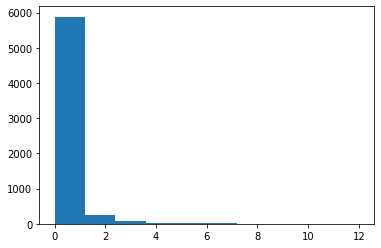

In [89]:
#Number of COOPs histogram
dfT = townData.df
plt.hist(dfT["shops"])

[51.0, 250.0, 359.40000000000003, 478.1, 625.0, 790.0, 981.1333333333334, 1311.8999999999999, 1863.2000000000003, 3089.999999999999]


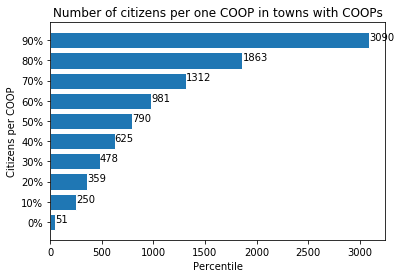

In [148]:
#Number of citizens per one COOP in towns with COOPs by quantiles
dfT1 = dfT[dfT["shops"]!=0]
l=[]
for indexT, rowT in dfT1.iterrows():
    i = rowT["totalN"]/rowT["shops"]
    l.append(i)
df = pd.DataFrame(l,columns=['data'])
bins = df["data"].quantile([0,.1,.2,.3,.4,.5,.6,.7,.8,.9]).to_list()
print(bins)
plt.barh(["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%"],bins,edgecolor="white")
plt.xlabel("Percentile")
plt.ylabel("Citizens per COOP")
plt.title("Number of citizens per one COOP in towns with COOPs")
#dfT1["data"]=l
#plt.hist(l,bins=[0, 250,1000, 5000, 10000],edgecolor="white")
for index, value in enumerate(bins):
    plt.text(value, index, str(round(value)))
#By ploting with the percentile, we can see how many citizens in towns belong to one shop. 90% of COOPs have less than 3100 citizens living in the area.

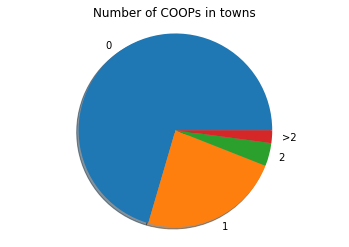

In [166]:
#Piechart Nuber of COOPs in towns
labels = "0", "1","2",">2"
sizes = [dfT['shops'].value_counts()[0],dfT['shops'].value_counts()[1],dfT['shops'].value_counts()[2],sum(dfT['shops'].value_counts()[3:])]
fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels,shadow=True)
ax1.axis("equal")
ax1.set_title("Number of COOPs in towns")
plt.show()

#In most towns there is no COOP shop, a little less than 1/4 towns have 1 shop and only few towns have more than 1 shop.